In [1]:
import torch

In [ ]:
import uproot
import yaml 

events = uproot.open("/eos/user/m/mgarciam/datasets_mlpf/Evaluation_datasets/all_E_notracker_pfo/pf_tree_1.root;:events;1")

: 

In [1]:
import torch
import sys
import torch
import os.path as osp
import tqdm
import sys
import numpy as np
sys.path.append('/afs/cern.ch/work/m/mgarciam/private/mlpf/')
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
import dgl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
class Args:
    def __init__(self):
        self.data_train = ["/eos/user/m/mgarciam/datasets_mlpf/120823_condor_spread_5_6/pf_tree_1.root"]
        self.data_val = ['/eos/user/m/mgarciam/datasets_mlpf/120823_condor_spread_5_6/pf_tree_1.root']
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/m/mgarciam/private/mlpf/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 2
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False
args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')

In [19]:
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                   extra_selection=args.extra_selection,
                                   remake_weights= True,
                                   load_range_and_fraction=(train_range, args.data_fraction),
                                   file_fraction=args.file_fraction,
                                   fetch_by_files=args.fetch_by_files,
                                   fetch_step=args.fetch_step,
                                   infinity_mode= False,
                                   in_memory=args.in_memory,
                                   async_load = False,
                                   name='train', dataset_cap=None)

In [20]:
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)

In [21]:
iterator = iter(train_loader)

=== Restarting DataIter train, seed=None ===


In [22]:
g, y = next(iterator)

In [23]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


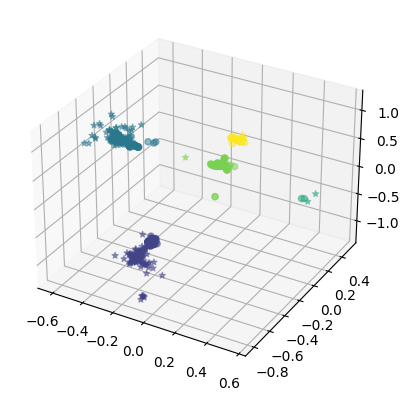

In [24]:

list_graphs = dgl.unbatch(g)
for gg in range(0,len(list_graphs)):
    g_eval=list_graphs[gg]
    pos = g_eval.ndata['pos_hits_norm']
    pos_xyz = g_eval.ndata['pos_hits_xyz']
    particle_id = g_eval.ndata['particle_number']
    particle_type = g_eval.ndata['hit_type']
    particle_type = torch.argmax(particle_type,dim=1)
    m=['k','l','l','k','j','l']
    mapping = {'j' : 'o', 'k': 'x', 'l': '+'}
    number_of_particles = len(np.unique(particle_id))
    mask_ecal = particle_type == 2
    mask_hcal = particle_type == 3
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range(1,number_of_particles+1):
        mask_particle = particle_id == i
        ax.scatter(pos_xyz[:,0][mask_ecal*mask_particle], pos_xyz[:,1][mask_ecal*mask_particle], pos_xyz[:,2][mask_ecal*mask_particle],marker='o', c = particle_id[mask_ecal*mask_particle], alpha=0.5, vmin=0, vmax=5)
        ax.scatter(pos_xyz[:,0][mask_hcal*mask_particle], pos_xyz[:,1][mask_hcal*mask_particle], pos_xyz[:,2][mask_hcal*mask_particle],marker='*', c = particle_id[mask_hcal*mask_particle], alpha=0.5,vmin=0, vmax=5)

15
15


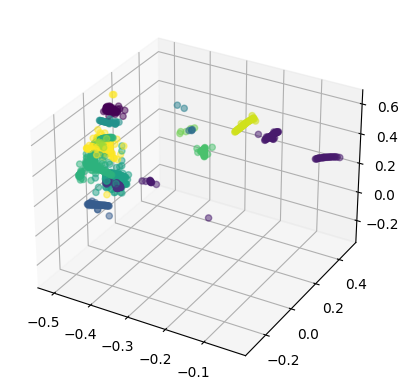

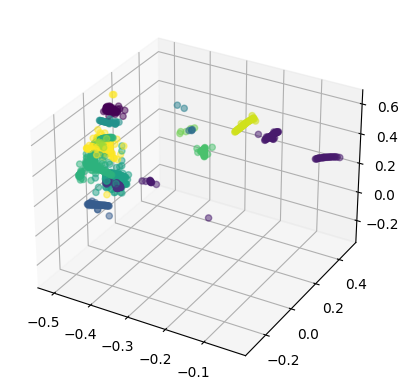

In [8]:
list_graphs = dgl.unbatch(g)
for i in range(len(list_graphs)):
    g_eval=list_graphs[i]
    pos = g_eval.ndata['pos_hits_norm']
    pos_xyz = g_eval.ndata['pos_hits_xyz']
    particle_id = g_eval.ndata['particle_number']
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    print(len(torch.unique(particle_id)))
    ax.scatter(pos_xyz[:,0], pos_xyz[:,1], pos_xyz[:,2],marker='o', c = particle_id, alpha=0.5)

: 

In [41]:
hit_x_ = np.abs(pos_xyz[:,0].numpy())
hit_x = pos_xyz[:,0].numpy()
def normalize_min_max(hit_x):
    hit_x_ = np.abs(hit_x)
    min = np.min(hit_x_)
    max = np.max(hit_x_)
    print(min,max)
    min_new_coord = 1-min/max

    new_hitx = min_new_coord*(hit_x-min)/(max-min)+np.sign(hit_x)*min/max
    return new_hitx



5.1 1533.5789


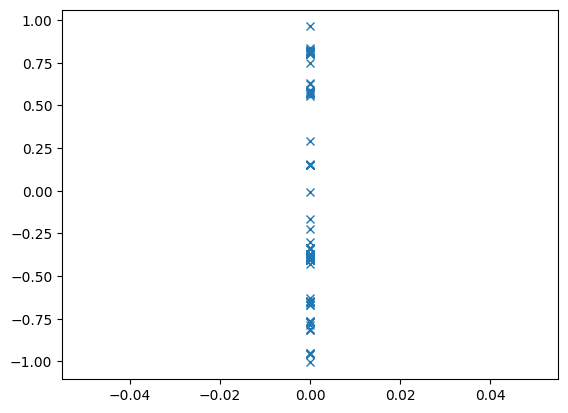

In [42]:
plt.plot(np.zeros(len(new_hitx)),new_hitx,'x')

In [32]:
hit_y = np.abs(pos_xyz[:,1].numpy())
min = np.min(hit_y)
max = np.max(hit_y)
print(min,max)
min_new_coord = 1-min/max

539.8383 1920.0


In [33]:
hit_z = np.abs(pos_xyz[:,2].numpy())
min = np.min(hit_z)
max = np.max(hit_z)
print(min,max)


15.0 2364.95


In [ ]:
A = g.ndata['pos_hits_norm'][:,:]
dist = torch.triu(torch.cdist(A, A, p=2)).flatten()
dist = dist[dist>0]
1/dist

: 

In [ ]:
from src.models.wrapper.example_gravnet_model import GraphTransformerNetWrapper
model = GraphTransformerNetWrapper('cpu',output_dim =4, n_postgn_dense_blocks=4, clust_space_norm = "tanh", k_gravnet=10)
# from src.models.wrapper.example_gattedGCN import GatedGCNNetWrapper
# model = GatedGCNNetWrapper('cpu')


new_model = "/afs/cern.ch/work/m/mgarciam/private/models/test_mlpf_qmin3/_epoch-10_state.pt"  # 16D clustering space
model.load_state_dict(torch.load(new_model, map_location='cpu'))

: 

In [35]:
pred = model(g)

In [36]:
np.unique(dgl.unbatch(g)[0].ndata['particle_number'].detach().numpy())

array([1., 2.], dtype=float32)

In [37]:
# import networkx as nx
# g_updated = dgl.unbatch(graphs[2])[1]
# G = dgl.to_networkx(g_updated)
# pca = PCA(n_components=2)
# pos_dic =pca.fit_transform(g_updated.ndata['s_l'].detach().numpy())
# graph0 = dgl.unbatch(g)[1]
# nx.draw(G, pos_dic,node_color = graph0.ndata['particle_number'].detach().numpy(), alpha=0.5)

In [38]:
clust_space_dim = 3
bj = torch.sigmoid(torch.reshape(pred[:, clust_space_dim], [-1, 1]))  # 3: betas
xj = pred[:, 0:clust_space_dim]  # xj: cluster space coords
xj = torch.tanh(xj)

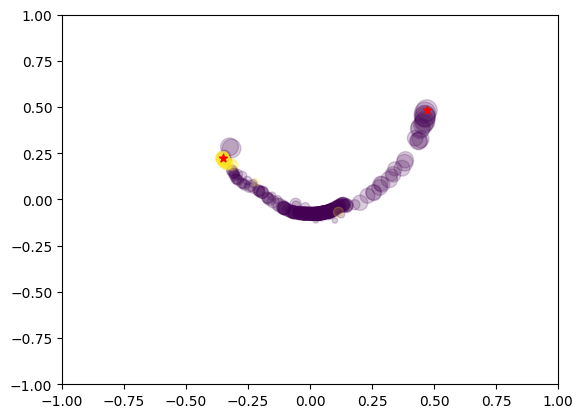

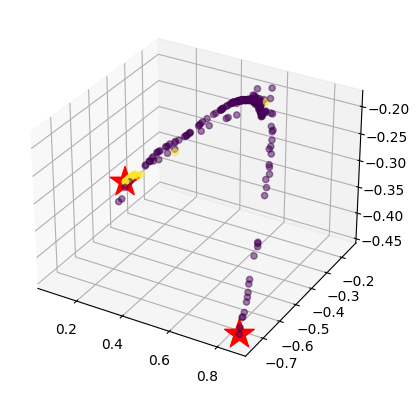

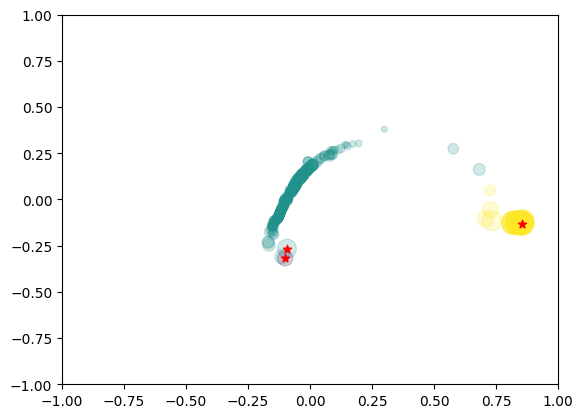

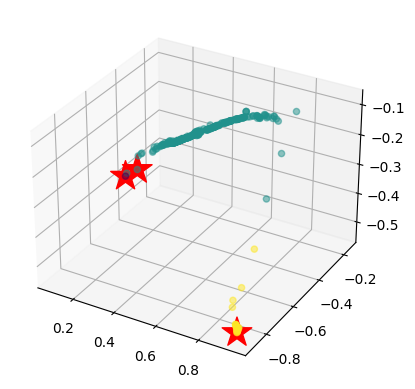

In [39]:
from torch_scatter import scatter_max, scatter_add, scatter_mean
list_graphs = dgl.unbatch(g)
node_counter=0
for i in range(0,len(list_graphs)):
    graph_eval = list_graphs[i]
    non = graph_eval.number_of_nodes()
    pos = graph_eval.ndata['pos_hits_norm']
    particle_id = graph_eval.ndata['particle_number']
    bj_graph = bj[node_counter:non+node_counter]
    xj_graph = xj[node_counter:non+node_counter]
    pca = PCA(n_components=2)
    PCA_2d_node_feats = pca.fit_transform(xj_graph.detach().cpu().numpy())
    q_graph = bj_graph.arctanh() ** 2 + 0.5
    q = q_graph.detach().numpy()
    part_num = graph_eval.ndata['particle_number'].view(-1).to(torch.long)
    q_alpha, index_alpha = scatter_max(q_graph.view(-1), part_num-1)
    plt.figure()
    plt.scatter(PCA_2d_node_feats[:,0], PCA_2d_node_feats[:,1], c=particle_id, alpha=0.2, s =500*bj_graph.detach().numpy())
    plt.scatter(PCA_2d_node_feats[index_alpha, 0],PCA_2d_node_feats[index_alpha, 1], marker='*', c ="r", alpha=1.)
    plt.ylim([-1,1])
    plt.xlim([-1,1])

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xj_graph[:,0].detach().cpu().numpy(), xj_graph[:,1].detach().cpu().numpy(), xj_graph[:,2].detach().cpu().numpy(),marker='o', c = particle_id, alpha=0.5)
    ax.scatter(xj_graph[index_alpha,0].detach().cpu().numpy(), xj_graph[index_alpha,1].detach().cpu().numpy(), xj_graph[index_alpha,2].detach().cpu().numpy(),marker='*', c = 'r', alpha=1, s=500)
    node_counter = node_counter +non

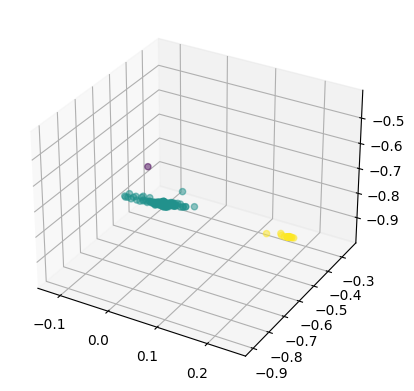

In [40]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pos[:,0], pos[:,1], pos[:,2],marker='o', c = particle_id, alpha=0.5)

In [45]:
q_sorted = np.flip(np.argsort(q.reshape(-1)))
particle_id[q_sorted[2]]

tensor(3.)

In [46]:
np.unique(graph_eval.ndata['particle_number'])

array([1., 2., 3.], dtype=float32)

In [47]:
torch.sum(bj_graph>0.7)

tensor(0)

<Axes: ylabel='Count'>

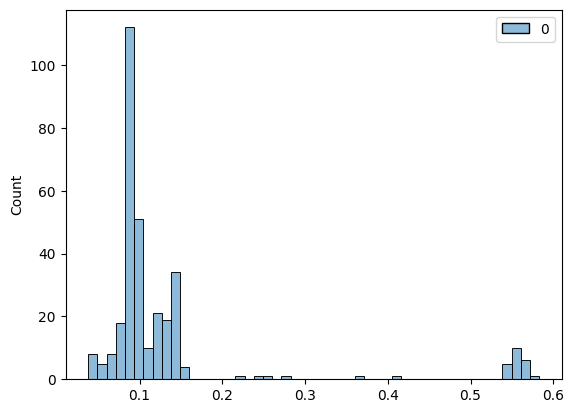

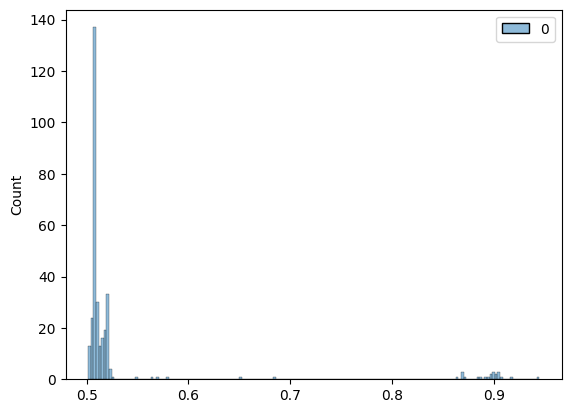

In [48]:
import seaborn
plt.figure()
seaborn.histplot(bj_graph.detach().numpy())
import seaborn
plt.figure()
seaborn.histplot(q)

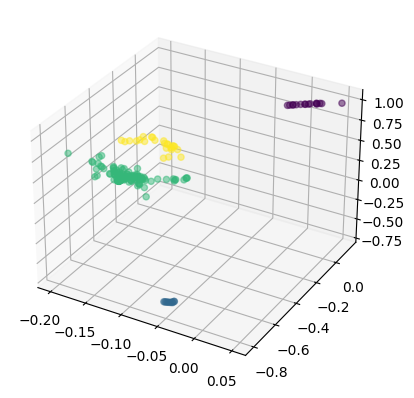

In [20]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pos[:,0], pos[:,1], pos[:,2],marker='o', c = particle_id, alpha=0.5)

In [15]:
from src.layers.object_cond import batch_cluster_indices, scatter_count, scatter_counts_to_indices, get_inter_event_norms_mask
from torch_scatter import scatter_max, scatter_add, scatter_mean
len_batch = len(g.batch_num_nodes())
batch_numbers = torch.repeat_interleave(
torch.range(0, len_batch - 1), g.batch_num_nodes()
)

beta= bj.view(-1)
cluster_space_coords= xj
cluster_index_per_event=  g.ndata["particle_number"].view(-1).long()
batch= batch_numbers.long()

qmin= 5
s_B= 1.0,
noise_cluster_index= 0,  # cluster_index entries with this value are noise/noise
beta_stabilizing="soft_q_scaling"
huberize_norm_for_V_attractive=False
beta_term_option="paper"
return_components=False
return_regression_resolution=False
clust_space_dim=3
frac_combinations=0.0  # fraction of the all possible pairs to be used for the clustering loss
attr_weight=1.0
repul_weight=1.0
fill_loss_weight=1.0

device = beta.device

cluster_index, n_clusters_per_event = batch_cluster_indices(
    cluster_index_per_event, batch
)

n_clusters = n_clusters_per_event.sum()
n_hits, cluster_space_dim = cluster_space_coords.size()
batch_size = batch.max() + 1
n_hits_per_event = scatter_count(batch)


# Index of cluster -> event (n_clusters,)
batch_cluster = scatter_counts_to_indices(n_clusters_per_event)

# Per-hit boolean, indicating whether hit is sig or noise
is_noise = cluster_index_per_event == 0

is_sig = ~is_noise
n_hits_sig = is_sig.sum()
n_sig_hits_per_event = scatter_count(batch[is_sig])

/tmp/mgarciam/ipykernel_20161/743559500.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(0, len_batch - 1), g.batch_num_nodes()


In [16]:
noise_cluster_index

(0,)

In [17]:


# Per-cluster boolean, indicating whether cluster is an object or noise
is_object = scatter_max(is_sig.long(), cluster_index)[0].bool()
is_noise_cluster = ~is_object

# FIXME: This assumes noise_cluster_index == 0!!
# Not sure how to do this in a performant way in case noise_cluster_index != 0

object_index_per_event = cluster_index_per_event[is_sig] - 1
object_index, n_objects_per_event = batch_cluster_indices(
    object_index_per_event, batch[is_sig]
)
n_hits_per_object = scatter_count(object_index)
# print("n_hits_per_object", n_hits_per_object)
batch_object = batch_cluster[is_object]
n_objects = is_object.sum()

assert object_index.size() == (n_hits_sig,)
assert is_object.size() == (n_clusters,)
assert torch.all(n_hits_per_object > 0)
assert object_index.max() + 1 == n_objects

# ________________________________
# L_V term

# Calculate q
if beta_stabilizing == "paper":
    q = beta.arctanh() ** 2 + qmin
elif beta_stabilizing == "clip":
    beta = beta.clip(0.0, 1 - 1e-4)
    q = beta.arctanh() ** 2 + qmin
elif beta_stabilizing == "soft_q_scaling":
    q = (beta.clip(0.0, 1 - 1e-4) / 1.002).arctanh() ** 2 + qmin
else:
    raise ValueError(f"beta_stablizing mode {beta_stabilizing} is not known")
assert q.device == device
assert q.size() == (n_hits,)

# Calculate q_alpha, the max q per object, and the indices of said maxima
q_alpha, index_alpha = scatter_max(q[is_sig], object_index)
assert q_alpha.size() == (n_objects,)

# Get the cluster space coordinates and betas for these maxima hits too
x_alpha = cluster_space_coords[is_sig][index_alpha]

beta_alpha = beta[is_sig][index_alpha]

In [18]:
counter_objects = 0
for i in range(0,len(n_objects_per_event)):
    objects = n_objects_per_event[i]
    x_alpha_event = x_alpha[counter_objects:objects+counter_objects]
    counter_objects +=objects
    A = x_alpha_event
    dist = torch.triu(torch.cdist(A, A, p=2)).flatten()
    dist = dist[dist>0]
    print(1/dist)


tensor([1.6972], grad_fn=<MulBackward0>)
tensor([34.5261,  1.5538,  1.6237], grad_fn=<MulBackward0>)


In [19]:
M = torch.nn.functional.one_hot(cluster_index).long()

# Anti-connectivity matrix; be sure not to connect hits to clusters in different events!
M_inv = get_inter_event_norms_mask(batch, n_clusters_per_event) - M

# Throw away noise cluster columns; we never need them
M = M[:, is_object]
M_inv = M_inv[:, is_object]
assert M.size() == (n_hits, n_objects)
assert M_inv.size() == (n_hits, n_objects)

# Calculate all norms
# Warning: Should not be used without a mask!
# Contains norms between hits and objects from different events
# (n_hits, 1, cluster_space_dim) - (1, n_objects, cluster_space_dim)
#   gives (n_hits, n_objects, cluster_space_dim)
norms = (cluster_space_coords.unsqueeze(1) - x_alpha.unsqueeze(0)).norm(dim=-1)
assert norms.size() == (n_hits, n_objects)

In [119]:
qmin = 3
list_graphs = dgl.unbatch(g)
loss_total = 0
number_particles_accounted_for = 0
node_counter = 0
for i in range(0,1):
    graph_eval = list_graphs[i]
    non = graph_eval.number_of_nodes()
    xj_graph = xj[node_counter:non+node_counter]
    bj_graph = bj[node_counter:non+node_counter]
    q_graph = bj_graph.arctanh() ** 2 + qmin
    q = q_graph.detach().numpy()
    part_num = graph_eval.ndata['particle_number'].view(-1).to(torch.long)
    q_alpha, index_alpha = scatter_max(q_graph.view(-1), part_num-1)
    x_alpha = xj_graph[index_alpha]
    number_of_particles = torch.unique(graph_eval.ndata['particle_number'])
    indx = torch.zeros((len(number_of_particles), 50)).to(x_alpha.device)
    b_alpha = bj_graph[index_alpha]
    if len(number_of_particles)>1:
        for nn in range(0,len(number_of_particles)):
            idx_part = number_of_particles[nn]
            positives_of_class = graph_eval.ndata['particle_number']==idx_part
            pos_indx = torch.where(positives_of_class==True)[0]
            if len(pos_indx)>50:
                indx[nn,:] = pos_indx[0:50]
            else:
                indx[nn,0:len(pos_indx)] = pos_indx
                indx[nn,len(pos_indx):] = pos_indx[0]
        for nn in range(0,len(number_of_particles)):
            idx_part = number_of_particles[nn]
            positives_of_class = graph_eval.ndata['particle_number']==idx_part
            xj_ = xj_graph[positives_of_class]
            x_alpha_ = x_alpha[nn]
            dot_products = torch.mul(xj_,x_alpha_.unsqueeze(0).tile((xj_.shape[0],1))).sum(dim=1)
            dot_products_exp = torch.exp(dot_products)
            indx_copy =indx.clone()
            indx_copy[nn]=-1
            indx_copy = indx_copy.view(-1)
            indx_copy = indx_copy[indx_copy>-1]
            neg_indx = indx_copy 
            xj_neg = xj_graph[neg_indx.long()]
            dot_neg = torch.sum(torch.exp(torch.tensordot(xj_, xj_neg, dims=([1],[1]))), dim=1)
            loss = torch.mean(-torch.log(dot_products / dot_neg))
            loss_total = loss_total+loss
            number_particles_accounted_for = number_particles_accounted_for+1
    loss_alpha = torch.sum((1-b_alpha))/len(b_alpha)
    print(loss_alpha)
loss_total = loss_total/number_particles_accounted_for
    



    

tensor(0.7232, grad_fn=<DivBackward0>)


In [123]:
bj_graph[index_alpha]= 0
torch.sum(torch.exp(10*bj_graph))/non

tensor(9.9389, grad_fn=<DivBackward0>)

In [23]:
xj_graph[0]

tensor([ 0.8651, -0.1485, -0.2613], grad_fn=<SelectBackward0>)

In [72]:
dot_products = torch.mul(cluster_space_coords.unsqueeze(1).tile((1,x_alpha.shape[0],1)),x_alpha.unsqueeze(0).tile((cluster_space_coords.shape[0],1,1))).sum(dim=2)
dot_products_exp = torch.exp(dot_products)

In [76]:
exp_att = M[is_sig]*dot_products_exp

In [77]:
exp_att

tensor([[0.0000, 1.2544, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2544, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2541, 0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000, 1.8981, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.8881, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9454]],
       grad_fn=<MulBackward0>)

In [79]:
exp_rep = M_inv[is_sig]*dot_products_exp

In [80]:
exp_rep

tensor([[1.6456, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6456, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6444, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 4.8762, 1.6825, 0.0000, 3.8401],
        [0.0000, 0.0000, 4.7260, 1.6760, 0.0000, 3.7602],
        [0.0000, 0.0000, 7.2553, 1.7403, 1.9921, 0.0000]],
       grad_fn=<MulBackward0>)

In [25]:
norms_att = norms[is_sig]

# Power-scale the norms
norms_att = norms_att**2
assert norms_att.size() == (n_hits_sig, n_objects)

# Now apply the mask to keep only norms of signal hits w.r.t. to the object
# they belong to
norms_att *= M[is_sig]

# Final potential term
# (n_sig_hits, 1) * (1, n_objects) * (n_sig_hits, n_objects)
V_attractive = q[is_sig].unsqueeze(-1) * q_alpha.unsqueeze(0) * norms_att
assert V_attractive.size() == (n_hits_sig, n_objects)

# Sum over hits, then sum per event, then divide by n_hits_per_event, then sum over events
V_attractive = scatter_add(V_attractive.sum(dim=0), batch_object) / n_hits_per_event
assert V_attractive.size() == (batch_size,)
L_V_attractive = V_attractive.sum()

In [79]:
norms_rep = torch.exp(-4.0 * norms**2) * M_inv

# (n_sig_hits, 1) * (1, n_objects) * (n_sig_hits, n_objects)
V_repulsive = q.unsqueeze(1) * q_alpha.unsqueeze(0) * norms_rep
# No need to apply a V = max(0, V); by construction V>=0
assert V_repulsive.size() == (n_hits, n_objects)

# Sum over hits, then sum per event, then divide by n_hits_per_event, then sum up events
L_V_repulsive = (
    scatter_add(V_repulsive.sum(dim=0), batch_object) / n_hits_per_event
).sum()

In [80]:
n_hits_per_event

tensor([ 805, 1063])

In [99]:
torch.exp(20*torch.Tensor([0.0]))-1

tensor([0.])

In [85]:
beta_exp = beta[is_sig]
beta_exp[index_alpha] = 0
scatter_add(torch.exp(5*beta_exp)-1,  batch)/ n_hits_per_event

tensor([ 9.6625, 14.6949], grad_fn=<DivBackward0>)

In [30]:
L_beta_sig = (scatter_add((1 - beta_alpha), batch_object) / n_objects_per_event)
L_beta_sig

tensor([0.3393, 0.2284], grad_fn=<DivBackward0>)

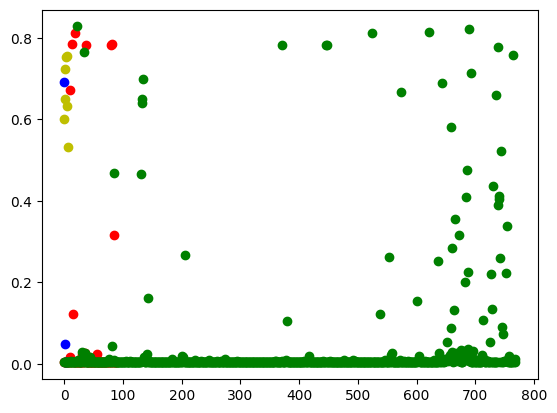

In [33]:
particle_id = list_graphs[1].ndata['particle_number']
plt.plot(beta.detach().numpy()[n_sig_hits_per_event[0]:][particle_id==1], 'o', color='r')
plt.plot(beta.detach().numpy()[n_sig_hits_per_event[0]:][particle_id==2], 'o', color='b')
plt.plot(beta.detach().numpy()[n_sig_hits_per_event[0]:][particle_id==3], 'o', color='g')
plt.plot(beta.detach().numpy()[n_sig_hits_per_event[0]:][particle_id==4], 'o', color='y')

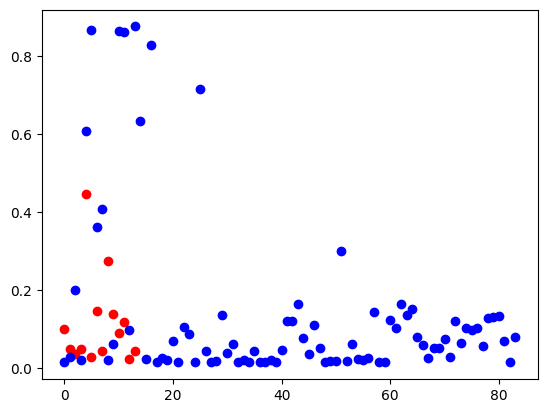

In [26]:
particle_id = list_graphs[0].ndata['particle_number']
plt.plot(beta.detach().numpy()[0:n_sig_hits_per_event[0]][particle_id==1], 'o', color='r')
plt.plot(beta.detach().numpy()[0:n_sig_hits_per_event[0]][particle_id==2], 'o', color='b')